In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm import tqdm_notebook 
import seaborn as sns
import imageio
import time
from IPython.display import HTML


from sklearn.preprocessing import OneHotEncoder
from sklearn.datasets import make_moons, make_blobs, make_circles

# Load data

In [0]:
data, labels = make_circles(n_samples=1000, random_state=0, noise=0.2, factor=0.3)
labels = labels.reshape(-1,1)
print(data.shape, labels.shape)

(1000, 2) (1000, 1)


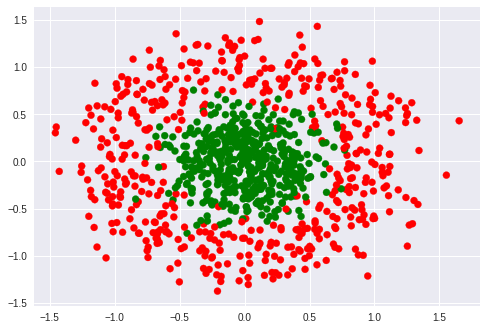

In [0]:
my_cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","yellow","green"])
plt.scatter(data[:,0], data[:,1], c=labels[:,0], cmap=my_cmap)
plt.show()

In [0]:
#Make train test split
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify=labels, random_state=0)
print(X_train.shape, Y_train.shape)

(750, 2) (750, 1)


# General Neuralnet Class

In [0]:
class NeuralNet:
  
  def __init__(self, nx, ny, hidden_sizes=[2]):
    self.nx = nx
    self.ny = ny
    self.nh = len(hidden_sizes)
    self.sizes = [self.nx] + hidden_sizes + [self.ny]
    
    self.W={}
    self.B={}
    
    for i in range(self.nh+1):
      self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
      self.B[i+1] = np.zeros((1,self.sizes[i]))
  
  def sigmoid(self, X):
    return(1.0/(1.0 + np.exp(-X)))
  
  def grad_sigmoid(self, X):
    return(X * (1-X))
  
  def forward_pass(self, X):
    self.A = {}
    self.H = {}
    self.H[0] = X
    for i in range(self.nh + 1):
      self.A[i+1] = np.matmul(self.H[i], self.W[i+1]) + self.B[i+1] #(Nx2).(2x2) -> (Nx2)
      self.H[i+1] = self.sigmoid(self.A[i+1]) #(Nx2) 
    return(self.H[self.nh+1])
  
  def grad(self, X, Y):
    self.forward_pass(X)
    self.dA, self.dH, self.dW, self.dB={},{},{},{}
    L = self.nh+1
    self.dA[L] = self.H[self.nh+1] - Y
    for i in range(L,0,-1):
      self.dW[i] = np.matmul(self.H[i-1].T, self.dA[i]) 
      self.dB[i] = np.sum(self.dA[i], axis=0) 
      self.dH[i-1] = np.matmul(self.dA[i], self.W[i].T)
      self.dA[i-1] = np.multiply(self.dH[i-1], self.grad_sigmoid(self.H[i-1]))
  
  def predict(self, X):
    Y_pred = self.forward_pass(X)
    return(np.array(Y_pred).squeeze())
  
  def fit(self, X, Y, epochs=1, learning_rate=1, initialize=True, display_loss=True):
    
    if(initialize):
      for i in range(self.nh+1):
        self.W[i+1] = np.random.randn(self.sizes[i], self.sizes[i+1])
        self.B[i+1] = np.zeros((1,self.sizes[i+1]))
      
    if(display_loss):
      loss={}
    
    for epoch in tqdm_notebook(range(epochs), total=epochs, unit='epoch'):
      self.grad(X, Y)
      
      m = X.shape[1]
      for i in range(self.nh+1):
        self.W[i+1] -= learning_rate * self.dW[i+1]/m
        self.B[i+1] -= learning_rate * self.dB[i+1]/m
      
      if(display_loss):
        Y_pred = self.predict(X)
        loss[epoch] = log_loss(Y, Y_pred)
      
    if(display_loss):
      plt.plot(loss.values())
      plt.title('Loss')
      plt.xlabel('epoch')
      plt.ylabel('Log loss')
      

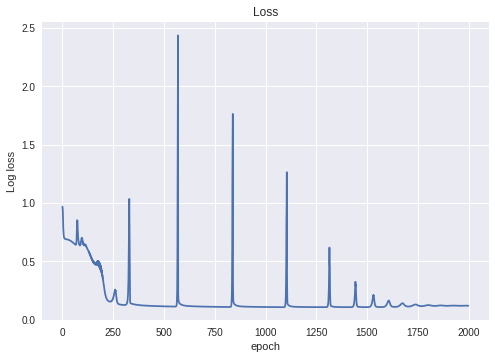

In [0]:
nnet = NeuralNet(2, 1, [3, 4])
nnet.fit(X_train, Y_train, epochs=2000, learning_rate=0.01)

In [0]:
Y_train_pred = nnet.predict(X_train)
Y_train_pred_binarized = (Y_train_pred > 0.5).astype('int').ravel()
Y_test_pred = nnet.predict(X_test)
Y_test_pred_binarized = (Y_test_pred > 0.5).astype('int').ravel()
train_acc = accuracy_score(Y_train, Y_train_pred_binarized)
test_acc  = accuracy_score(Y_test, Y_test_pred_binarized)
print(train_acc, test_acc)

0.9546666666666667 0.952


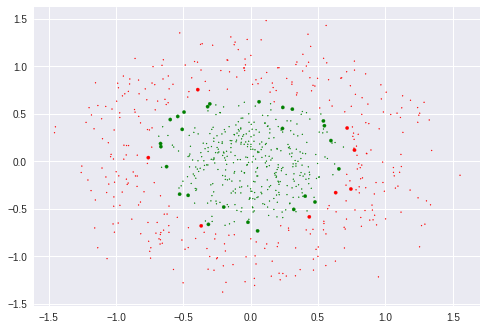

In [0]:
Y_train_reshaped = Y_train.reshape(Y_train_pred_binarized.shape)
plt.scatter(X_train[:,0], X_train[:,1], c=Y_train_pred_binarized, cmap=my_cmap, s=10*(np.abs(Y_train_pred_binarized - Y_train_reshaped)+0.1))
plt.show()